In [1]:
!pip install torch==1.12
!pip install torchvision==0.13
!pip install nltk==3.7
!pip install torchtext==0.13.1
!pip install networkx==2.8.5
!pip install torchviz==0.0.2
!pip install matplotlib==3.5.2
!pip install scikit-image==0.19.3
!pip install gym==0.25.1
!pip install atari-py==0.2.9
!pip install opencv-python==4.6.0.66
!pip install autoPyTorch==0.0.2
!pip install torchviz==0.0.2
!pip install configspace==0.5.0
!pip install git+https://github.com/shukon/HpBandSter.git
!pip install captum==0.5.0

  Using cached torch-1.12.0-cp39-none-macosx_10_9_x86_64.whl (133.6 MB)
  Attempting uninstall: torch
    Found existing installation: torch 1.12.1
    Uninstalling torch-1.12.1:
      Successfully uninstalled torch-1.12.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.13.1 requires torch==1.12.1, but you have torch 1.12.0 which is incompatible.
torchtext 0.13.1 requires torch==1.12.1, but you have torch 1.12.0 which is incompatible.
torchdata 0.4.1 requires torch==1.12.1, but you have torch 1.12.0 which is incompatible.
  Using cached torchvision-0.13.0-cp39-cp39-macosx_10_9_x86_64.whl (1.3 MB)
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.13.1
    Uninstalling torchvision-0.13.1:
      Successfully uninstalled torchvision-0.13.1
  Using cached torch-1.12.1-cp39-none-macosx_10_9_x86_64.whl (133.8 MB)


  Attempting uninstall: torch
    Found existing installation: torch 1.12.0
    Uninstalling torch-1.12.0:
      Successfully uninstalled torch-1.12.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.13.0 requires torch==1.12.0, but you have torch 1.12.1 which is incompatible.


  Using cached autoPyTorch-0.0.2-py3-none-any.whl (312 kB)


  Using cached scikit_learn-1.1.2-cp39-cp39-macosx_10_9_x86_64.whl (8.7 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.2
    Uninstalling scikit-learn-0.24.2:
      Successfully uninstalled scikit-learn-0.24.2
  Attempting uninstall: autoPyTorch
    Found existing installation: autoPyTorch 0.2.1
    Uninstalling autoPyTorch-0.2.1:
      Successfully uninstalled autoPyTorch-0.2.1


  Using cached ConfigSpace-0.5.0-cp39-cp39-macosx_10_9_x86_64.whl (966 kB)
  Attempting uninstall: configspace
    Found existing installation: ConfigSpace 0.6.0
    Uninstalling ConfigSpace-0.6.0:
      Successfully uninstalled ConfigSpace-0.6.0
  Cloning https://github.com/shukon/HpBandSter.git to /private/var/folders/gs/mjlw0j210yz02z4yrv9gshdm0000gq/T/pip-req-build-8n563e6j
  Running command git clone --filter=blob:none --quiet https://github.com/shukon/HpBandSter.git /private/var/folders/gs/mjlw0j210yz02z4yrv9gshdm0000gq/T/pip-req-build-8n563e6j
  Resolved https://github.com/shukon/HpBandSter.git to commit 89eb5337a4841077d00b238f75b8e2ad9c37476f
  Preparing metadata (setup.py) ... done


## import modules

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np

In [4]:
np.random.seed(123)
torch.use_deterministic_algorithms(True)

## define model architecture

In [5]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.cn1 = nn.Conv2d(1, 16, 3, 1)
        self.cn2 = nn.Conv2d(16, 32, 3, 1)
        self.dp1 = nn.Dropout2d(0.10)
        self.dp2 = nn.Dropout2d(0.25)
        self.fc1 = nn.Linear(4608, 64) # 4608 is basically 12 X 12 X 32
        self.fc2 = nn.Linear(64, 10)
 
    def forward(self, x):
        x = self.cn1(x)
        x = F.relu(x)
        x = self.cn2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dp1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dp2(x)
        x = self.fc2(x)
        op = F.log_softmax(x, dim=1)
        return op

## define training and inference routines

In [6]:
def train(model, device, train_dataloader, optim, epoch):
    model.train()
    for b_i, (X, y) in enumerate(train_dataloader):
        X, y = X.to(device), y.to(device)
        optim.zero_grad()
        pred_prob = model(X)
        loss = F.nll_loss(pred_prob, y) # nll is the negative likelihood loss
        loss.backward()
        optim.step()
        if b_i % 10 == 0:
            print('epoch: {} [{}/{} ({:.0f}%)]\t training loss: {:.6f}'.format(
                epoch, b_i * len(X), len(train_dataloader.dataset),
                100. * b_i / len(train_dataloader), loss.item()))

In [7]:
def test(model, device, test_dataloader):
    model.eval()
    loss = 0
    success = 0
    with torch.no_grad():
        for X, y in test_dataloader:
            X, y = X.to(device), y.to(device)
            pred_prob = model(X)
            loss += F.nll_loss(pred_prob, y, reduction='sum').item()  # loss summed across the batch
            pred = pred_prob.argmax(dim=1, keepdim=True)  # us argmax to get the most likely prediction
            success += pred.eq(y.view_as(pred)).sum().item()

    loss /= len(test_dataloader.dataset)

    print('\nTest dataset: Overall Loss: {:.4f}, Overall Accuracy: {}/{} ({:.0f}%)\n'.format(
        loss, success, len(test_dataloader.dataset),
        100. * success / len(test_dataloader.dataset)))


## create data loaders

In [8]:
# The mean and standard deviation values are calculated as the mean of all pixel values of all images in the training dataset
train_dataloader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1302,), (0.3069,))])), # train_X.mean()/256. and train_X.std()/256.
    batch_size=32, shuffle=True)

test_dataloader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, 
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1302,), (0.3069,)) 
                   ])),
    batch_size=500, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



## define optimizer and run training epochs

In [9]:
device = torch.device("cpu")

model = ConvNet()
optimizer = optim.Adadelta(model.parameters(), lr=0.5)

## model training

In [10]:
for epoch in range(1, 20):
    train(model, device, train_dataloader, optimizer, epoch)
    test(model, device, test_dataloader)

epoch: 1 [0/60000 (0%)]	 training loss: 2.333742


/Users/ashish.jha/opt/anaconda3/envs/mastering_pytorch/lib/python3.9/site-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


epoch: 1 [320/60000 (1%)]	 training loss: 1.504298
epoch: 1 [640/60000 (1%)]	 training loss: 1.336827
epoch: 1 [960/60000 (2%)]	 training loss: 0.684411
epoch: 1 [1280/60000 (2%)]	 training loss: 0.434219
epoch: 1 [1600/60000 (3%)]	 training loss: 0.608343
epoch: 1 [1920/60000 (3%)]	 training loss: 0.770463
epoch: 1 [2240/60000 (4%)]	 training loss: 0.431585
epoch: 1 [2560/60000 (4%)]	 training loss: 0.372163
epoch: 1 [2880/60000 (5%)]	 training loss: 0.409993
epoch: 1 [3200/60000 (5%)]	 training loss: 0.579152
epoch: 1 [3520/60000 (6%)]	 training loss: 0.550262
epoch: 1 [3840/60000 (6%)]	 training loss: 0.527237
epoch: 1 [4160/60000 (7%)]	 training loss: 0.099100
epoch: 1 [4480/60000 (7%)]	 training loss: 0.480612
epoch: 1 [4800/60000 (8%)]	 training loss: 0.444318
epoch: 1 [5120/60000 (9%)]	 training loss: 0.243250
epoch: 1 [5440/60000 (9%)]	 training loss: 0.404903
epoch: 1 [5760/60000 (10%)]	 training loss: 0.373952
epoch: 1 [6080/60000 (10%)]	 training loss: 0.062566
epoch: 1 [640

epoch: 1 [49280/60000 (82%)]	 training loss: 0.063890
epoch: 1 [49600/60000 (83%)]	 training loss: 0.157850
epoch: 1 [49920/60000 (83%)]	 training loss: 0.050877
epoch: 1 [50240/60000 (84%)]	 training loss: 0.029393
epoch: 1 [50560/60000 (84%)]	 training loss: 0.156317
epoch: 1 [50880/60000 (85%)]	 training loss: 0.256441
epoch: 1 [51200/60000 (85%)]	 training loss: 0.013070
epoch: 1 [51520/60000 (86%)]	 training loss: 0.082736
epoch: 1 [51840/60000 (86%)]	 training loss: 0.052154
epoch: 1 [52160/60000 (87%)]	 training loss: 0.149190
epoch: 1 [52480/60000 (87%)]	 training loss: 0.040126
epoch: 1 [52800/60000 (88%)]	 training loss: 0.019928
epoch: 1 [53120/60000 (89%)]	 training loss: 0.017528
epoch: 1 [53440/60000 (89%)]	 training loss: 0.337962
epoch: 1 [53760/60000 (90%)]	 training loss: 0.068636
epoch: 1 [54080/60000 (90%)]	 training loss: 0.156115
epoch: 1 [54400/60000 (91%)]	 training loss: 0.072559
epoch: 1 [54720/60000 (91%)]	 training loss: 0.019566
epoch: 1 [55040/60000 (92%)]

epoch: 2 [37760/60000 (63%)]	 training loss: 0.054520
epoch: 2 [38080/60000 (63%)]	 training loss: 0.023639
epoch: 2 [38400/60000 (64%)]	 training loss: 0.050625
epoch: 2 [38720/60000 (65%)]	 training loss: 0.049475
epoch: 2 [39040/60000 (65%)]	 training loss: 0.016467
epoch: 2 [39360/60000 (66%)]	 training loss: 0.098247
epoch: 2 [39680/60000 (66%)]	 training loss: 0.025398
epoch: 2 [40000/60000 (67%)]	 training loss: 0.056281
epoch: 2 [40320/60000 (67%)]	 training loss: 0.010923
epoch: 2 [40640/60000 (68%)]	 training loss: 0.157137
epoch: 2 [40960/60000 (68%)]	 training loss: 0.073890
epoch: 2 [41280/60000 (69%)]	 training loss: 0.247721
epoch: 2 [41600/60000 (69%)]	 training loss: 0.289163
epoch: 2 [41920/60000 (70%)]	 training loss: 0.042822
epoch: 2 [42240/60000 (70%)]	 training loss: 0.092192
epoch: 2 [42560/60000 (71%)]	 training loss: 0.071724
epoch: 2 [42880/60000 (71%)]	 training loss: 0.279847
epoch: 2 [43200/60000 (72%)]	 training loss: 0.006946
epoch: 2 [43520/60000 (73%)]

epoch: 3 [26240/60000 (44%)]	 training loss: 0.001953
epoch: 3 [26560/60000 (44%)]	 training loss: 0.010675
epoch: 3 [26880/60000 (45%)]	 training loss: 0.020778
epoch: 3 [27200/60000 (45%)]	 training loss: 0.037570
epoch: 3 [27520/60000 (46%)]	 training loss: 0.003347
epoch: 3 [27840/60000 (46%)]	 training loss: 0.003525
epoch: 3 [28160/60000 (47%)]	 training loss: 0.177683
epoch: 3 [28480/60000 (47%)]	 training loss: 0.139199
epoch: 3 [28800/60000 (48%)]	 training loss: 0.011186
epoch: 3 [29120/60000 (49%)]	 training loss: 0.072172
epoch: 3 [29440/60000 (49%)]	 training loss: 0.347907
epoch: 3 [29760/60000 (50%)]	 training loss: 0.034505
epoch: 3 [30080/60000 (50%)]	 training loss: 0.017343
epoch: 3 [30400/60000 (51%)]	 training loss: 0.002645
epoch: 3 [30720/60000 (51%)]	 training loss: 0.016769
epoch: 3 [31040/60000 (52%)]	 training loss: 0.008808
epoch: 3 [31360/60000 (52%)]	 training loss: 0.017758
epoch: 3 [31680/60000 (53%)]	 training loss: 0.037998
epoch: 3 [32000/60000 (53%)]

epoch: 4 [14720/60000 (25%)]	 training loss: 0.003741
epoch: 4 [15040/60000 (25%)]	 training loss: 0.000813
epoch: 4 [15360/60000 (26%)]	 training loss: 0.068797
epoch: 4 [15680/60000 (26%)]	 training loss: 0.224664
epoch: 4 [16000/60000 (27%)]	 training loss: 0.065075
epoch: 4 [16320/60000 (27%)]	 training loss: 0.076946
epoch: 4 [16640/60000 (28%)]	 training loss: 0.146455
epoch: 4 [16960/60000 (28%)]	 training loss: 0.074993
epoch: 4 [17280/60000 (29%)]	 training loss: 0.184979
epoch: 4 [17600/60000 (29%)]	 training loss: 0.013511
epoch: 4 [17920/60000 (30%)]	 training loss: 0.009074
epoch: 4 [18240/60000 (30%)]	 training loss: 0.006931
epoch: 4 [18560/60000 (31%)]	 training loss: 0.140665
epoch: 4 [18880/60000 (31%)]	 training loss: 0.003836
epoch: 4 [19200/60000 (32%)]	 training loss: 0.006270
epoch: 4 [19520/60000 (33%)]	 training loss: 0.001274
epoch: 4 [19840/60000 (33%)]	 training loss: 0.004944
epoch: 4 [20160/60000 (34%)]	 training loss: 0.027002
epoch: 4 [20480/60000 (34%)]

epoch: 5 [2880/60000 (5%)]	 training loss: 0.018190
epoch: 5 [3200/60000 (5%)]	 training loss: 0.002218
epoch: 5 [3520/60000 (6%)]	 training loss: 0.007195
epoch: 5 [3840/60000 (6%)]	 training loss: 0.045235
epoch: 5 [4160/60000 (7%)]	 training loss: 0.025732
epoch: 5 [4480/60000 (7%)]	 training loss: 0.055758
epoch: 5 [4800/60000 (8%)]	 training loss: 0.077755
epoch: 5 [5120/60000 (9%)]	 training loss: 0.071746
epoch: 5 [5440/60000 (9%)]	 training loss: 0.007385
epoch: 5 [5760/60000 (10%)]	 training loss: 0.003910
epoch: 5 [6080/60000 (10%)]	 training loss: 0.005028
epoch: 5 [6400/60000 (11%)]	 training loss: 0.092706
epoch: 5 [6720/60000 (11%)]	 training loss: 0.006512
epoch: 5 [7040/60000 (12%)]	 training loss: 0.020855
epoch: 5 [7360/60000 (12%)]	 training loss: 0.000657
epoch: 5 [7680/60000 (13%)]	 training loss: 0.000102
epoch: 5 [8000/60000 (13%)]	 training loss: 0.043879
epoch: 5 [8320/60000 (14%)]	 training loss: 0.017966
epoch: 5 [8640/60000 (14%)]	 training loss: 0.008892
ep

epoch: 5 [51840/60000 (86%)]	 training loss: 0.040532
epoch: 5 [52160/60000 (87%)]	 training loss: 0.050741
epoch: 5 [52480/60000 (87%)]	 training loss: 0.008119
epoch: 5 [52800/60000 (88%)]	 training loss: 0.000579
epoch: 5 [53120/60000 (89%)]	 training loss: 0.006972
epoch: 5 [53440/60000 (89%)]	 training loss: 0.078877
epoch: 5 [53760/60000 (90%)]	 training loss: 0.000191
epoch: 5 [54080/60000 (90%)]	 training loss: 0.148032
epoch: 5 [54400/60000 (91%)]	 training loss: 0.130252
epoch: 5 [54720/60000 (91%)]	 training loss: 0.003896
epoch: 5 [55040/60000 (92%)]	 training loss: 0.045337
epoch: 5 [55360/60000 (92%)]	 training loss: 0.119234
epoch: 5 [55680/60000 (93%)]	 training loss: 0.011376
epoch: 5 [56000/60000 (93%)]	 training loss: 0.094953
epoch: 5 [56320/60000 (94%)]	 training loss: 0.007692
epoch: 5 [56640/60000 (94%)]	 training loss: 0.065174
epoch: 5 [56960/60000 (95%)]	 training loss: 0.037893
epoch: 5 [57280/60000 (95%)]	 training loss: 0.038788
epoch: 5 [57600/60000 (96%)]

epoch: 6 [40320/60000 (67%)]	 training loss: 0.003660
epoch: 6 [40640/60000 (68%)]	 training loss: 0.000429
epoch: 6 [40960/60000 (68%)]	 training loss: 0.015669
epoch: 6 [41280/60000 (69%)]	 training loss: 0.003110
epoch: 6 [41600/60000 (69%)]	 training loss: 0.048850
epoch: 6 [41920/60000 (70%)]	 training loss: 0.005604
epoch: 6 [42240/60000 (70%)]	 training loss: 0.002697
epoch: 6 [42560/60000 (71%)]	 training loss: 0.075975
epoch: 6 [42880/60000 (71%)]	 training loss: 0.020993
epoch: 6 [43200/60000 (72%)]	 training loss: 0.022629
epoch: 6 [43520/60000 (73%)]	 training loss: 0.012391
epoch: 6 [43840/60000 (73%)]	 training loss: 0.011194
epoch: 6 [44160/60000 (74%)]	 training loss: 0.023555
epoch: 6 [44480/60000 (74%)]	 training loss: 0.058529
epoch: 6 [44800/60000 (75%)]	 training loss: 0.017773
epoch: 6 [45120/60000 (75%)]	 training loss: 0.011848
epoch: 6 [45440/60000 (76%)]	 training loss: 0.007662
epoch: 6 [45760/60000 (76%)]	 training loss: 0.013875
epoch: 6 [46080/60000 (77%)]

epoch: 7 [28800/60000 (48%)]	 training loss: 0.005807
epoch: 7 [29120/60000 (49%)]	 training loss: 0.003252
epoch: 7 [29440/60000 (49%)]	 training loss: 0.027020
epoch: 7 [29760/60000 (50%)]	 training loss: 0.021654
epoch: 7 [30080/60000 (50%)]	 training loss: 0.003781
epoch: 7 [30400/60000 (51%)]	 training loss: 0.014285
epoch: 7 [30720/60000 (51%)]	 training loss: 0.003351
epoch: 7 [31040/60000 (52%)]	 training loss: 0.012495
epoch: 7 [31360/60000 (52%)]	 training loss: 0.026920
epoch: 7 [31680/60000 (53%)]	 training loss: 0.000143
epoch: 7 [32000/60000 (53%)]	 training loss: 0.062240
epoch: 7 [32320/60000 (54%)]	 training loss: 0.015457
epoch: 7 [32640/60000 (54%)]	 training loss: 0.002383
epoch: 7 [32960/60000 (55%)]	 training loss: 0.000854
epoch: 7 [33280/60000 (55%)]	 training loss: 0.002539
epoch: 7 [33600/60000 (56%)]	 training loss: 0.004571
epoch: 7 [33920/60000 (57%)]	 training loss: 0.000849
epoch: 7 [34240/60000 (57%)]	 training loss: 0.128169
epoch: 7 [34560/60000 (58%)]

epoch: 8 [17280/60000 (29%)]	 training loss: 0.000097
epoch: 8 [17600/60000 (29%)]	 training loss: 0.063902
epoch: 8 [17920/60000 (30%)]	 training loss: 0.002406
epoch: 8 [18240/60000 (30%)]	 training loss: 0.011788
epoch: 8 [18560/60000 (31%)]	 training loss: 0.000605
epoch: 8 [18880/60000 (31%)]	 training loss: 0.000376
epoch: 8 [19200/60000 (32%)]	 training loss: 0.086203
epoch: 8 [19520/60000 (33%)]	 training loss: 0.027951
epoch: 8 [19840/60000 (33%)]	 training loss: 0.006056
epoch: 8 [20160/60000 (34%)]	 training loss: 0.003202
epoch: 8 [20480/60000 (34%)]	 training loss: 0.097283
epoch: 8 [20800/60000 (35%)]	 training loss: 0.000174
epoch: 8 [21120/60000 (35%)]	 training loss: 0.002739
epoch: 8 [21440/60000 (36%)]	 training loss: 0.000307
epoch: 8 [21760/60000 (36%)]	 training loss: 0.020901
epoch: 8 [22080/60000 (37%)]	 training loss: 0.008474
epoch: 8 [22400/60000 (37%)]	 training loss: 0.004543
epoch: 8 [22720/60000 (38%)]	 training loss: 0.011096
epoch: 8 [23040/60000 (38%)]

epoch: 9 [5760/60000 (10%)]	 training loss: 0.006193
epoch: 9 [6080/60000 (10%)]	 training loss: 0.003409
epoch: 9 [6400/60000 (11%)]	 training loss: 0.080023
epoch: 9 [6720/60000 (11%)]	 training loss: 0.000781
epoch: 9 [7040/60000 (12%)]	 training loss: 0.034253
epoch: 9 [7360/60000 (12%)]	 training loss: 0.145042
epoch: 9 [7680/60000 (13%)]	 training loss: 0.002235
epoch: 9 [8000/60000 (13%)]	 training loss: 0.022299
epoch: 9 [8320/60000 (14%)]	 training loss: 0.014746
epoch: 9 [8640/60000 (14%)]	 training loss: 0.006864
epoch: 9 [8960/60000 (15%)]	 training loss: 0.019474
epoch: 9 [9280/60000 (15%)]	 training loss: 0.001319
epoch: 9 [9600/60000 (16%)]	 training loss: 0.057379
epoch: 9 [9920/60000 (17%)]	 training loss: 0.004524
epoch: 9 [10240/60000 (17%)]	 training loss: 0.002960
epoch: 9 [10560/60000 (18%)]	 training loss: 0.000753
epoch: 9 [10880/60000 (18%)]	 training loss: 0.001434
epoch: 9 [11200/60000 (19%)]	 training loss: 0.169119
epoch: 9 [11520/60000 (19%)]	 training los

epoch: 9 [54400/60000 (91%)]	 training loss: 0.007623
epoch: 9 [54720/60000 (91%)]	 training loss: 0.003892
epoch: 9 [55040/60000 (92%)]	 training loss: 0.017158
epoch: 9 [55360/60000 (92%)]	 training loss: 0.001837
epoch: 9 [55680/60000 (93%)]	 training loss: 0.019947
epoch: 9 [56000/60000 (93%)]	 training loss: 0.000730
epoch: 9 [56320/60000 (94%)]	 training loss: 0.001058
epoch: 9 [56640/60000 (94%)]	 training loss: 0.014184
epoch: 9 [56960/60000 (95%)]	 training loss: 0.012189
epoch: 9 [57280/60000 (95%)]	 training loss: 0.008740
epoch: 9 [57600/60000 (96%)]	 training loss: 0.015054
epoch: 9 [57920/60000 (97%)]	 training loss: 0.004392
epoch: 9 [58240/60000 (97%)]	 training loss: 0.009528
epoch: 9 [58560/60000 (98%)]	 training loss: 0.055119
epoch: 9 [58880/60000 (98%)]	 training loss: 0.009891
epoch: 9 [59200/60000 (99%)]	 training loss: 0.003818
epoch: 9 [59520/60000 (99%)]	 training loss: 0.004166
epoch: 9 [59840/60000 (100%)]	 training loss: 0.178950

Test dataset: Overall Loss

epoch: 10 [42240/60000 (70%)]	 training loss: 0.004667
epoch: 10 [42560/60000 (71%)]	 training loss: 0.003273
epoch: 10 [42880/60000 (71%)]	 training loss: 0.159519
epoch: 10 [43200/60000 (72%)]	 training loss: 0.044993
epoch: 10 [43520/60000 (73%)]	 training loss: 0.007863
epoch: 10 [43840/60000 (73%)]	 training loss: 0.002072
epoch: 10 [44160/60000 (74%)]	 training loss: 0.014165
epoch: 10 [44480/60000 (74%)]	 training loss: 0.329461
epoch: 10 [44800/60000 (75%)]	 training loss: 0.002623
epoch: 10 [45120/60000 (75%)]	 training loss: 0.092762
epoch: 10 [45440/60000 (76%)]	 training loss: 0.003307
epoch: 10 [45760/60000 (76%)]	 training loss: 0.002195
epoch: 10 [46080/60000 (77%)]	 training loss: 0.001148
epoch: 10 [46400/60000 (77%)]	 training loss: 0.018594
epoch: 10 [46720/60000 (78%)]	 training loss: 0.000153
epoch: 10 [47040/60000 (78%)]	 training loss: 0.083433
epoch: 10 [47360/60000 (79%)]	 training loss: 0.004734
epoch: 10 [47680/60000 (79%)]	 training loss: 0.015791
epoch: 10 

epoch: 11 [29760/60000 (50%)]	 training loss: 0.000132
epoch: 11 [30080/60000 (50%)]	 training loss: 0.010404
epoch: 11 [30400/60000 (51%)]	 training loss: 0.002291
epoch: 11 [30720/60000 (51%)]	 training loss: 0.042407
epoch: 11 [31040/60000 (52%)]	 training loss: 0.004871
epoch: 11 [31360/60000 (52%)]	 training loss: 0.001691
epoch: 11 [31680/60000 (53%)]	 training loss: 0.000192
epoch: 11 [32000/60000 (53%)]	 training loss: 0.097722
epoch: 11 [32320/60000 (54%)]	 training loss: 0.007583
epoch: 11 [32640/60000 (54%)]	 training loss: 0.001757
epoch: 11 [32960/60000 (55%)]	 training loss: 0.005953
epoch: 11 [33280/60000 (55%)]	 training loss: 0.002415
epoch: 11 [33600/60000 (56%)]	 training loss: 0.061409
epoch: 11 [33920/60000 (57%)]	 training loss: 0.000374
epoch: 11 [34240/60000 (57%)]	 training loss: 0.000012
epoch: 11 [34560/60000 (58%)]	 training loss: 0.000087
epoch: 11 [34880/60000 (58%)]	 training loss: 0.155124
epoch: 11 [35200/60000 (59%)]	 training loss: 0.005680
epoch: 11 

epoch: 12 [17280/60000 (29%)]	 training loss: 0.000235
epoch: 12 [17600/60000 (29%)]	 training loss: 0.050121
epoch: 12 [17920/60000 (30%)]	 training loss: 0.016432
epoch: 12 [18240/60000 (30%)]	 training loss: 0.000581
epoch: 12 [18560/60000 (31%)]	 training loss: 0.032073
epoch: 12 [18880/60000 (31%)]	 training loss: 0.019073
epoch: 12 [19200/60000 (32%)]	 training loss: 0.000349
epoch: 12 [19520/60000 (33%)]	 training loss: 0.004057
epoch: 12 [19840/60000 (33%)]	 training loss: 0.002394
epoch: 12 [20160/60000 (34%)]	 training loss: 0.000623
epoch: 12 [20480/60000 (34%)]	 training loss: 0.181253
epoch: 12 [20800/60000 (35%)]	 training loss: 0.009851
epoch: 12 [21120/60000 (35%)]	 training loss: 0.161440
epoch: 12 [21440/60000 (36%)]	 training loss: 0.008279
epoch: 12 [21760/60000 (36%)]	 training loss: 0.014098
epoch: 12 [22080/60000 (37%)]	 training loss: 0.290747
epoch: 12 [22400/60000 (37%)]	 training loss: 0.000239
epoch: 12 [22720/60000 (38%)]	 training loss: 0.003604
epoch: 12 

epoch: 13 [4800/60000 (8%)]	 training loss: 0.000720
epoch: 13 [5120/60000 (9%)]	 training loss: 0.006018
epoch: 13 [5440/60000 (9%)]	 training loss: 0.011282
epoch: 13 [5760/60000 (10%)]	 training loss: 0.015014
epoch: 13 [6080/60000 (10%)]	 training loss: 0.019038
epoch: 13 [6400/60000 (11%)]	 training loss: 0.000303
epoch: 13 [6720/60000 (11%)]	 training loss: 0.008882
epoch: 13 [7040/60000 (12%)]	 training loss: 0.004318
epoch: 13 [7360/60000 (12%)]	 training loss: 0.004444
epoch: 13 [7680/60000 (13%)]	 training loss: 0.004412
epoch: 13 [8000/60000 (13%)]	 training loss: 0.000613
epoch: 13 [8320/60000 (14%)]	 training loss: 0.003034
epoch: 13 [8640/60000 (14%)]	 training loss: 0.026215
epoch: 13 [8960/60000 (15%)]	 training loss: 0.000137
epoch: 13 [9280/60000 (15%)]	 training loss: 0.003974
epoch: 13 [9600/60000 (16%)]	 training loss: 0.002260
epoch: 13 [9920/60000 (17%)]	 training loss: 0.000534
epoch: 13 [10240/60000 (17%)]	 training loss: 0.001399
epoch: 13 [10560/60000 (18%)]	

epoch: 13 [52800/60000 (88%)]	 training loss: 0.000047
epoch: 13 [53120/60000 (89%)]	 training loss: 0.004283
epoch: 13 [53440/60000 (89%)]	 training loss: 0.000205
epoch: 13 [53760/60000 (90%)]	 training loss: 0.039162
epoch: 13 [54080/60000 (90%)]	 training loss: 0.002861
epoch: 13 [54400/60000 (91%)]	 training loss: 0.010838
epoch: 13 [54720/60000 (91%)]	 training loss: 0.050820
epoch: 13 [55040/60000 (92%)]	 training loss: 0.000033
epoch: 13 [55360/60000 (92%)]	 training loss: 0.185890
epoch: 13 [55680/60000 (93%)]	 training loss: 0.000187
epoch: 13 [56000/60000 (93%)]	 training loss: 0.059440
epoch: 13 [56320/60000 (94%)]	 training loss: 0.000224
epoch: 13 [56640/60000 (94%)]	 training loss: 0.015784
epoch: 13 [56960/60000 (95%)]	 training loss: 0.002524
epoch: 13 [57280/60000 (95%)]	 training loss: 0.001106
epoch: 13 [57600/60000 (96%)]	 training loss: 0.000138
epoch: 13 [57920/60000 (97%)]	 training loss: 0.071033
epoch: 13 [58240/60000 (97%)]	 training loss: 0.000162
epoch: 13 

epoch: 14 [40320/60000 (67%)]	 training loss: 0.021639
epoch: 14 [40640/60000 (68%)]	 training loss: 0.002966
epoch: 14 [40960/60000 (68%)]	 training loss: 0.007757
epoch: 14 [41280/60000 (69%)]	 training loss: 0.002163
epoch: 14 [41600/60000 (69%)]	 training loss: 0.029250
epoch: 14 [41920/60000 (70%)]	 training loss: 0.049484
epoch: 14 [42240/60000 (70%)]	 training loss: 0.000030
epoch: 14 [42560/60000 (71%)]	 training loss: 0.000092
epoch: 14 [42880/60000 (71%)]	 training loss: 0.137855
epoch: 14 [43200/60000 (72%)]	 training loss: 0.004490
epoch: 14 [43520/60000 (73%)]	 training loss: 0.003624
epoch: 14 [43840/60000 (73%)]	 training loss: 0.042385
epoch: 14 [44160/60000 (74%)]	 training loss: 0.002559
epoch: 14 [44480/60000 (74%)]	 training loss: 0.031025
epoch: 14 [44800/60000 (75%)]	 training loss: 0.000239
epoch: 14 [45120/60000 (75%)]	 training loss: 0.436764
epoch: 14 [45440/60000 (76%)]	 training loss: 0.007362
epoch: 14 [45760/60000 (76%)]	 training loss: 0.001524
epoch: 14 

epoch: 15 [28160/60000 (47%)]	 training loss: 0.016440
epoch: 15 [28480/60000 (47%)]	 training loss: 0.109084
epoch: 15 [28800/60000 (48%)]	 training loss: 0.079342
epoch: 15 [29120/60000 (49%)]	 training loss: 0.000022
epoch: 15 [29440/60000 (49%)]	 training loss: 0.061371
epoch: 15 [29760/60000 (50%)]	 training loss: 0.002196
epoch: 15 [30080/60000 (50%)]	 training loss: 0.002558
epoch: 15 [30400/60000 (51%)]	 training loss: 0.023348
epoch: 15 [30720/60000 (51%)]	 training loss: 0.002387
epoch: 15 [31040/60000 (52%)]	 training loss: 0.002678
epoch: 15 [31360/60000 (52%)]	 training loss: 0.000169
epoch: 15 [31680/60000 (53%)]	 training loss: 0.001035
epoch: 15 [32000/60000 (53%)]	 training loss: 0.003888
epoch: 15 [32320/60000 (54%)]	 training loss: 0.002187
epoch: 15 [32640/60000 (54%)]	 training loss: 0.007836
epoch: 15 [32960/60000 (55%)]	 training loss: 0.083940
epoch: 15 [33280/60000 (55%)]	 training loss: 0.012527
epoch: 15 [33600/60000 (56%)]	 training loss: 0.000313
epoch: 15 

epoch: 16 [15680/60000 (26%)]	 training loss: 0.000421
epoch: 16 [16000/60000 (27%)]	 training loss: 0.000206
epoch: 16 [16320/60000 (27%)]	 training loss: 0.000862
epoch: 16 [16640/60000 (28%)]	 training loss: 0.001722
epoch: 16 [16960/60000 (28%)]	 training loss: 0.000014
epoch: 16 [17280/60000 (29%)]	 training loss: 0.025071
epoch: 16 [17600/60000 (29%)]	 training loss: 0.000786
epoch: 16 [17920/60000 (30%)]	 training loss: 0.000176
epoch: 16 [18240/60000 (30%)]	 training loss: 0.006509
epoch: 16 [18560/60000 (31%)]	 training loss: 0.392423
epoch: 16 [18880/60000 (31%)]	 training loss: 0.001598
epoch: 16 [19200/60000 (32%)]	 training loss: 0.122854
epoch: 16 [19520/60000 (33%)]	 training loss: 0.065816
epoch: 16 [19840/60000 (33%)]	 training loss: 0.001760
epoch: 16 [20160/60000 (34%)]	 training loss: 0.007275
epoch: 16 [20480/60000 (34%)]	 training loss: 0.013118
epoch: 16 [20800/60000 (35%)]	 training loss: 0.000760
epoch: 16 [21120/60000 (35%)]	 training loss: 0.107477
epoch: 16 

epoch: 17 [3200/60000 (5%)]	 training loss: 0.005832
epoch: 17 [3520/60000 (6%)]	 training loss: 0.000369
epoch: 17 [3840/60000 (6%)]	 training loss: 0.038796
epoch: 17 [4160/60000 (7%)]	 training loss: 0.002477
epoch: 17 [4480/60000 (7%)]	 training loss: 0.111183
epoch: 17 [4800/60000 (8%)]	 training loss: 0.003587
epoch: 17 [5120/60000 (9%)]	 training loss: 0.005276
epoch: 17 [5440/60000 (9%)]	 training loss: 0.010138
epoch: 17 [5760/60000 (10%)]	 training loss: 0.000631
epoch: 17 [6080/60000 (10%)]	 training loss: 0.000040
epoch: 17 [6400/60000 (11%)]	 training loss: 0.000165
epoch: 17 [6720/60000 (11%)]	 training loss: 0.168261
epoch: 17 [7040/60000 (12%)]	 training loss: 0.032778
epoch: 17 [7360/60000 (12%)]	 training loss: 0.023042
epoch: 17 [7680/60000 (13%)]	 training loss: 0.100290
epoch: 17 [8000/60000 (13%)]	 training loss: 0.062186
epoch: 17 [8320/60000 (14%)]	 training loss: 0.107635
epoch: 17 [8640/60000 (14%)]	 training loss: 0.002756
epoch: 17 [8960/60000 (15%)]	 traini

epoch: 17 [51200/60000 (85%)]	 training loss: 0.070297
epoch: 17 [51520/60000 (86%)]	 training loss: 0.000202
epoch: 17 [51840/60000 (86%)]	 training loss: 0.001157
epoch: 17 [52160/60000 (87%)]	 training loss: 0.000169
epoch: 17 [52480/60000 (87%)]	 training loss: 0.000103
epoch: 17 [52800/60000 (88%)]	 training loss: 0.000020
epoch: 17 [53120/60000 (89%)]	 training loss: 0.000130
epoch: 17 [53440/60000 (89%)]	 training loss: 0.011921
epoch: 17 [53760/60000 (90%)]	 training loss: 0.003096
epoch: 17 [54080/60000 (90%)]	 training loss: 0.000181
epoch: 17 [54400/60000 (91%)]	 training loss: 0.045832
epoch: 17 [54720/60000 (91%)]	 training loss: 0.000399
epoch: 17 [55040/60000 (92%)]	 training loss: 0.000600
epoch: 17 [55360/60000 (92%)]	 training loss: 0.092749
epoch: 17 [55680/60000 (93%)]	 training loss: 0.000370
epoch: 17 [56000/60000 (93%)]	 training loss: 0.000009
epoch: 17 [56320/60000 (94%)]	 training loss: 0.020051
epoch: 17 [56640/60000 (94%)]	 training loss: 0.000141
epoch: 17 

epoch: 18 [38720/60000 (65%)]	 training loss: 0.028883
epoch: 18 [39040/60000 (65%)]	 training loss: 0.000872
epoch: 18 [39360/60000 (66%)]	 training loss: 0.001147
epoch: 18 [39680/60000 (66%)]	 training loss: 0.056013
epoch: 18 [40000/60000 (67%)]	 training loss: 0.159671
epoch: 18 [40320/60000 (67%)]	 training loss: 0.017505
epoch: 18 [40640/60000 (68%)]	 training loss: 0.004328
epoch: 18 [40960/60000 (68%)]	 training loss: 0.003501
epoch: 18 [41280/60000 (69%)]	 training loss: 0.014652
epoch: 18 [41600/60000 (69%)]	 training loss: 0.003805
epoch: 18 [41920/60000 (70%)]	 training loss: 0.000783
epoch: 18 [42240/60000 (70%)]	 training loss: 0.000116
epoch: 18 [42560/60000 (71%)]	 training loss: 0.011686
epoch: 18 [42880/60000 (71%)]	 training loss: 0.001366
epoch: 18 [43200/60000 (72%)]	 training loss: 0.000139
epoch: 18 [43520/60000 (73%)]	 training loss: 0.073795
epoch: 18 [43840/60000 (73%)]	 training loss: 0.000104
epoch: 18 [44160/60000 (74%)]	 training loss: 0.047211
epoch: 18 

epoch: 19 [26560/60000 (44%)]	 training loss: 0.000801
epoch: 19 [26880/60000 (45%)]	 training loss: 0.000048
epoch: 19 [27200/60000 (45%)]	 training loss: 0.004701
epoch: 19 [27520/60000 (46%)]	 training loss: 0.000807
epoch: 19 [27840/60000 (46%)]	 training loss: 0.000352
epoch: 19 [28160/60000 (47%)]	 training loss: 0.003419
epoch: 19 [28480/60000 (47%)]	 training loss: 0.001661
epoch: 19 [28800/60000 (48%)]	 training loss: 0.095073
epoch: 19 [29120/60000 (49%)]	 training loss: 0.000490
epoch: 19 [29440/60000 (49%)]	 training loss: 0.142101
epoch: 19 [29760/60000 (50%)]	 training loss: 0.000082
epoch: 19 [30080/60000 (50%)]	 training loss: 0.000288
epoch: 19 [30400/60000 (51%)]	 training loss: 0.000223
epoch: 19 [30720/60000 (51%)]	 training loss: 0.000349
epoch: 19 [31040/60000 (52%)]	 training loss: 0.001759
epoch: 19 [31360/60000 (52%)]	 training loss: 0.000032
epoch: 19 [31680/60000 (53%)]	 training loss: 0.004315
epoch: 19 [32000/60000 (53%)]	 training loss: 0.000585
epoch: 19 

## run inference on trained model

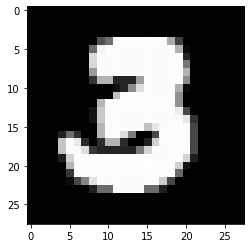

In [11]:
test_samples = enumerate(test_dataloader)
b_i, (sample_data, sample_targets) = next(test_samples)

plt.imshow(sample_data[0][0], cmap='gray', interpolation='none')
plt.show()

In [12]:
print(f"Model prediction is : {model(sample_data).data.max(1)[1][0]}")
print(f"Ground truth is : {sample_targets[0]}")

Model prediction is : 3
Ground truth is : 3


### visualize filters

In [13]:
model_children_list = list(model.children())
convolutional_layers = []
model_parameters = []
model_children_list

[Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1)),
 Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1)),
 Dropout2d(p=0.1, inplace=False),
 Dropout2d(p=0.25, inplace=False),
 Linear(in_features=4608, out_features=64, bias=True),
 Linear(in_features=64, out_features=10, bias=True)]

In [14]:
for i in range(len(model_children_list)):
    if type(model_children_list[i]) == nn.Conv2d:
        model_parameters.append(model_children_list[i].weight)
        convolutional_layers.append(model_children_list[i])

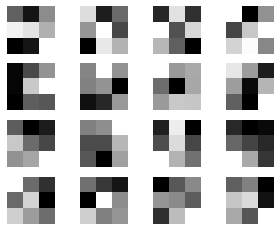

In [15]:
plt.figure(figsize=(5, 4))
for i, flt in enumerate(model_parameters[0]):
    plt.subplot(4, 4, i+1)
    plt.imshow(flt[0, :, :].detach(), cmap='gray')
    plt.axis('off')
plt.show()

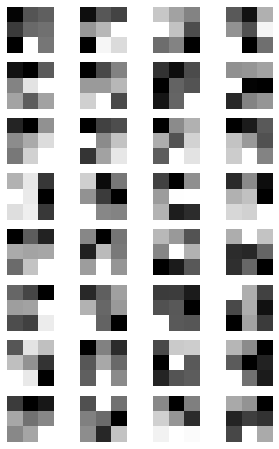

In [16]:
plt.figure(figsize=(5, 8))
for i, flt in enumerate(model_parameters[1]):
    plt.subplot(8, 4, i+1)
    plt.imshow(flt[0, :, :].detach(), cmap='gray')
    plt.axis('off')
plt.show()

### visualize feature maps

In [17]:
per_layer_results = [convolutional_layers[0](sample_data)]
for i in range(1, len(convolutional_layers)):
    per_layer_results.append(convolutional_layers[i](per_layer_results[-1]))

torch.Size([16, 26, 26])


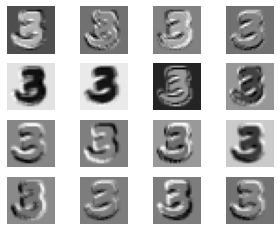

In [18]:
plt.figure(figsize=(5, 4))
layer_visualisation = per_layer_results[0][0, :, :, :]
layer_visualisation = layer_visualisation.data
print(layer_visualisation.size())
for i, flt in enumerate(layer_visualisation):
    plt.subplot(4, 4, i + 1)
    plt.imshow(flt, cmap='gray')
    plt.axis("off")
plt.show()

torch.Size([32, 24, 24])


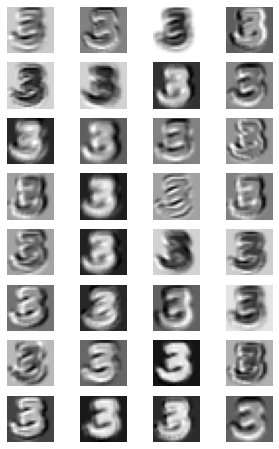

In [19]:
plt.figure(figsize=(5, 8))
layer_visualisation = per_layer_results[1][0, :, :, :]
layer_visualisation = layer_visualisation.data
print(layer_visualisation.size())
for i, flt in enumerate(layer_visualisation):
    plt.subplot(8, 4, i + 1)
    plt.imshow(flt, cmap='gray')
    plt.axis("off")
plt.show()